## Analysis of Survey Data for AI vs. Human-Generated Messages



#### Load Modules

In [1]:
import sys, os
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style("ticks")


#### Load and inspect data

In [2]:
#df = pd.read_csv('../../data/uae_survey_cleaned_reversed_reduced_avg.csv')
#df.head(3)

In [3]:
df = pd.read_csv('../../data/uae_survey_cleaned_reversed_reduced_avg_fatalism_scales_errorcorrected.csv')
df.head(3)

,Duration (in seconds),Exlcude_Speed,Finished,clarity_ai_mw_01_1,clarity_ai_mw_02_1,clarity_ai_mw_03_1,clarity_ai_mw_04_1,clarity_ai_mw_05_1,clarity_ai_wd_01_1,clarity_ai_wd_02_1,...,nationality,work,car_driving,religion,marital,education_years,income,women_driver_status,migrant_worker_status,young_driver_status
0,472,1,1,5,4,4,3,4,4,4,...,uae,job,1.0,muslim,single,4.0,125000.0,1,0,0
1,413,1,1,4,3,3,1,3,5,4,...,uae,student,4.0,muslim,single,1.0,65000.0,1,0,1
2,669,1,1,4,3,5,1,4,3,4,...,saudi,NaN,6.0,muslim,single,3.0,30000.0,0,1,0


In [4]:
df.describe()

,Duration (in seconds),Exlcude_Speed,Finished,clarity_ai_mw_01_1,clarity_ai_mw_02_1,clarity_ai_mw_03_1,clarity_ai_mw_04_1,clarity_ai_mw_05_1,clarity_ai_wd_01_1,clarity_ai_wd_02_1,...,age,gender_1man_2woman,english_first_language_0no_1yes,time_in_uae(1alllife|2=0-3yrs|3=4-7yrs|9morethan8years),car_driving,education_years,income,women_driver_status,migrant_worker_status,young_driver_status
count,117.000000,117.0,117.0,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,...,94.000000,115.000000,117.000000,116.000000,105.000000,114.000000,110.000000,117.000000,117.000000,117.000000
mean,867.538462,1.0,1.0,4.145299,3.897436,4.059829,3.786325,3.854701,3.837607,3.854701,...,22.500000,1.765217,0.119658,2.034483,-13.050476,2.877193,52772.727273,0.512821,0.256410,0.427350
std,476.900979,0.0,0.0,1.219560,1.199027,1.191135,1.325018,1.240585,1.338793,1.378811,...,5.237889,0.445847,0.325957,2.512338,39.518447,1.785588,43386.392635,0.501985,0.438529,0.496822
min,300.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,18.000000,1.000000,0.000000,1.000000,-99.000000,0.000000,10000.000000,0.000000,0.000000,0.000000
25%,547.000000,1.0,1.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,19.000000,2.000000,0.000000,1.000000,1.000000,1.250000,30000.000000,0.000000,0.000000,0.000000
50%,763.000000,1.0,1.0,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,...,20.500000,2.000000,0.000000,1.000000,2.000000,3.000000,30000.000000,1.000000,0.000000,0.000000
75%,1043.000000,1.0,1.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,23.000000,2.000000,0.000000,1.000000,5.000000,4.000000,65000.000000,1.000000,1.000000,1.000000
max,3428.000000,1.0,1.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,49.000000,3.000000,1.000000,9.000000,22.000000,6.000000,150000.000000,1.000000,1.000000,1.000000



### reshape DF and prepare for analysis by subjects, items


In [5]:
def convert_to_sub_pattern(num):
    return f'sub{str(num + 1).zfill(3)}'

In [6]:
# quality first
sub_df = df.filter(regex = 'quali',axis=1)
sub_df.reset_index(inplace=True)
sub_df = sub_df.rename(columns={'index': 'index_col'}).copy()
sub_df['sub_index'] = sub_df['index_col'].map(convert_to_sub_pattern)
sub_df = sub_df.drop('index_col', axis=1)

melted_df = pd.melt(sub_df, id_vars=['sub_index'], var_name='all_messages', value_name='message_evaluation')
sorted_melted_df = melted_df.sort_values(by='sub_index') 

sorted_melted_df['source'] = 'No'  # Initialize with default value
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_ai_'), 'source'] = 'AI'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_hum_'), 'source'] = 'Human'

sorted_melted_df['theme'] = 'No'  
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_mw_'), 'theme'] = 'Migrant Workers'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_wd_'), 'theme'] = 'Women Drivers'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_yd_'), 'theme'] = 'Young Drivers'

sorted_melted_df = sorted_melted_df.sort_values(by=['sub_index', 'all_messages'], ascending=[True, True])
desired_order = ['sub_index', 'source', 'theme', 'all_messages', 'message_evaluation']  # Specify the desired column order
sorted_melted_df = sorted_melted_df[desired_order]
sorted_melted_df.reset_index(inplace=True)

fatal_df = df.filter(regex = 'Fatal',axis=1)
fatal_df.reset_index(inplace=True)
fatal_df = fatal_df.rename(columns={'index': 'index_col'}).copy()
fatal_df['sub_index'] = fatal_df['index_col'].map(convert_to_sub_pattern)
fatal_df = fatal_df.drop('index_col', axis=1)

fs_df = pd.merge(sorted_melted_df, fatal_df, on='sub_index')
fs_df.to_csv('../../data/melted_quality_fatal_df.csv', index = False)

fs_df.tail()

,index,sub_index,source,theme,all_messages,message_evaluation,Fatalism_DivineControl,Fatalism_Luck,Fatalism_Internality-R,Fatalism_General
3505,3041,sub117,Human,Young Drivers,quality_hum_yd_01_1,5.0,5.0,5.0,1.0,5.0
3506,3158,sub117,Human,Young Drivers,quality_hum_yd_02_1,5.0,5.0,5.0,1.0,5.0
3507,3275,sub117,Human,Young Drivers,quality_hum_yd_03_1,5.0,5.0,5.0,1.0,5.0
3508,3392,sub117,Human,Young Drivers,quality_hum_yd_04_1,5.0,5.0,5.0,1.0,5.0
3509,3509,sub117,Human,Young Drivers,quality_hum_yd_05_1,5.0,5.0,5.0,1.0,5.0


In [7]:
# clarity second
sub_df = df.filter(regex = 'clari',axis=1)
sub_df.reset_index(inplace=True)
sub_df = sub_df.rename(columns={'index': 'index_col'}).copy()
sub_df['sub_index'] = sub_df['index_col'].map(convert_to_sub_pattern)
sub_df = sub_df.drop('index_col', axis=1)

melted_df = pd.melt(sub_df, id_vars=['sub_index'], var_name='all_messages', value_name='message_evaluation')
sorted_melted_df = melted_df.sort_values(by='sub_index') 

sorted_melted_df['source'] = 'No'  # Initialize with default value
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_ai_'), 'source'] = 'AI'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_hum_'), 'source'] = 'Human'

sorted_melted_df['theme'] = 'No'  
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_mw_'), 'theme'] = 'Migrant Workers'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_wd_'), 'theme'] = 'Women Drivers'
sorted_melted_df.loc[sorted_melted_df['all_messages'].str.contains('_yd_'), 'theme'] = 'Young Drivers'

sorted_melted_df = sorted_melted_df.sort_values(by=['sub_index', 'all_messages'], ascending=[True, True])
desired_order = ['sub_index', 'source', 'theme', 'all_messages', 'message_evaluation']  # Specify the desired column order
sorted_melted_df = sorted_melted_df[desired_order]
sorted_melted_df.reset_index(inplace=True)

fatal_df = df.filter(regex = 'Fatal',axis=1)
fatal_df.reset_index(inplace=True)
fatal_df = fatal_df.rename(columns={'index': 'index_col'}).copy()
fatal_df['sub_index'] = fatal_df['index_col'].map(convert_to_sub_pattern)
fatal_df = fatal_df.drop('index_col', axis=1)

fs_df = pd.merge(sorted_melted_df, fatal_df, on='sub_index')
fs_df.to_csv('../../data/melted_clarity_fatal_df.csv', index = False)

fs_df.tail()

,index,sub_index,source,theme,all_messages,message_evaluation,Fatalism_DivineControl,Fatalism_Luck,Fatalism_Internality-R,Fatalism_General
3505,3041,sub117,Human,Young Drivers,clarity_hum_yd_01_1,5.0,5.0,5.0,1.0,5.0
3506,3158,sub117,Human,Young Drivers,clarity_hum_yd_02_1,5.0,5.0,5.0,1.0,5.0
3507,3275,sub117,Human,Young Drivers,clarity_hum_yd_03_1,5.0,5.0,5.0,1.0,5.0
3508,3392,sub117,Human,Young Drivers,clarity_hum_yd_04_1,5.0,5.0,5.0,1.0,5.0
3509,3509,sub117,Human,Young Drivers,clarity_hum_yd_05_1,5.0,5.0,5.0,1.0,5.0


<Axes: >

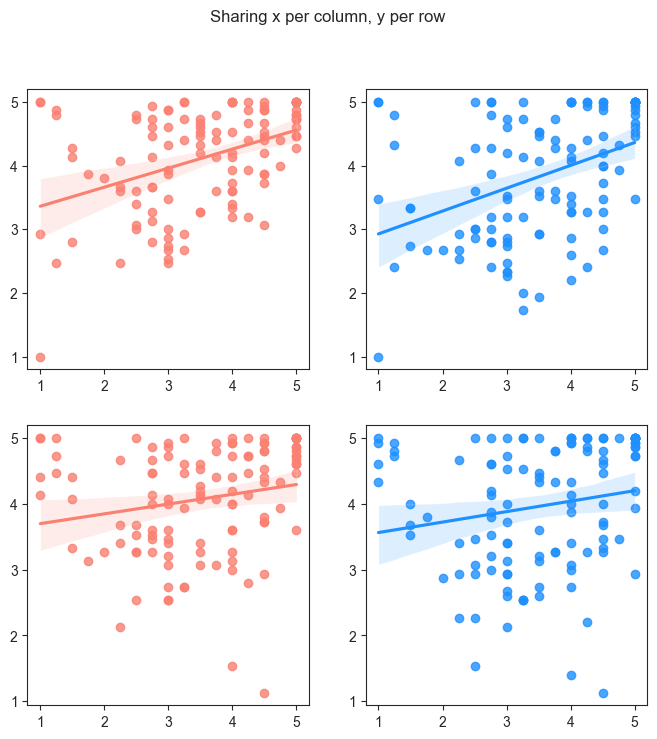

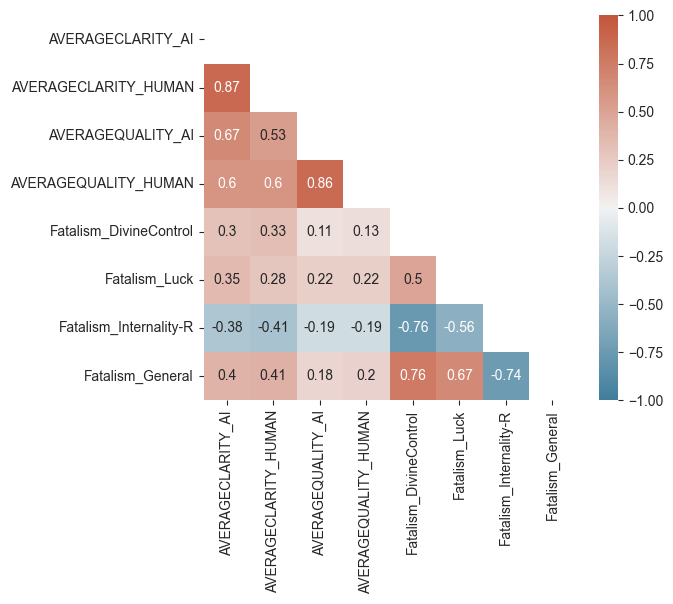

In [8]:
df2 = pd.DataFrame({'AVERAGECLARITY_AI': df.filter(regex = 'AVERAGECLARITY_AI',axis=1).values.ravel(),
                    'AVERAGECLARITY_HUMAN': df.filter(regex = 'AVERAGECLARITY_HUMAN',axis=1).values.ravel(),
                    'AVERAGEQUALITY_AI': df.filter(regex = 'AVERAGEQUALITY_AI',axis=1).values.ravel(),
                    'AVERAGEQUALITY_HUMAN': df.filter(regex = 'AVERAGEQUALITY_HUMAN',axis=1).values.ravel(),
                    'FATALISM_GENERAL': df.filter(regex = 'Fatalism_General',axis=1).values.ravel()
                    })
df2['AVG_CLARITY'] = df[['AVERAGECLARITY_AI', 'AVERAGECLARITY_HUMAN']].mean(axis=1)
df2['AVG_QUALITY'] = df[['AVERAGEQUALITY_AI', 'AVERAGEQUALITY_HUMAN']].mean(axis=1)

#df2

####

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8,8))
fig.suptitle('Sharing x per column, y per row')


sns.regplot(data=df2, y = 'AVERAGECLARITY_HUMAN', x = 'FATALISM_GENERAL', color = 'salmon',  ax = ax1);
sns.regplot(data=df2, y = 'AVERAGECLARITY_AI',    x = 'FATALISM_GENERAL', color = 'dodgerblue', ax = ax2);
sns.regplot(data=df2, y = 'AVERAGEQUALITY_HUMAN', x ='FATALISM_GENERAL', color = 'salmon', ax = ax3);
sns.regplot(data=df2, y = 'AVERAGEQUALITY_AI',  x = 'FATALISM_GENERAL', color = 'dodgerblue', ax = ax4);

ax1.set_xlabel(''); ax1.set_ylabel('');
ax2.set_xlabel(''); ax2.set_ylabel('');
ax3.set_xlabel(''); ax3.set_ylabel('');
ax4.set_xlabel(''); ax4.set_ylabel('');

ax1.set_xticks(np.arange(1,6,1)); ax1.set_yticks(np.arange(1,6,1)); 
ax2.set_xticks(np.arange(1,6,1)); ax2.set_yticks(np.arange(1,6,1)); 
ax3.set_xticks(np.arange(1,6,1)); ax3.set_yticks(np.arange(1,6,1)); 
ax4.set_xticks(np.arange(1,6,1)); ax4.set_yticks(np.arange(1,6,1)); 

np.corrcoef(df2.AVERAGECLARITY_HUMAN, df2.FATALISM_GENERAL)[0,1]


###


corr = df[['AVERAGECLARITY_AI', 'AVERAGECLARITY_HUMAN', 'AVERAGEQUALITY_AI', 'AVERAGEQUALITY_HUMAN',
           'Fatalism_DivineControl', 'Fatalism_Luck', 'Fatalism_Internality-R', 'Fatalism_General']].corr()

f, ax = plt.subplots(figsize=(6, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, vmin = -1, vmax = 1)